In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [9]:
filename = 'data/MEBL3/MEBL3_Pressure-data-2024-06-28 09_40_08.csv'
pressure_df = pd.read_csv(filename, parse_dates=['Time'])    
print(f"{filename} : file read into a pandas dataframe.")

pressure_df

data/MEBL3/MEBL3_Pressure-data-2024-06-28 09_40_08.csv : file read into a pandas dataframe.


,Time,Chamber Pressure,Column Pressure
0,2024-06-14 01:55:29,1.850000e-07,5.550000e-10
1,2024-06-14 01:55:30,1.840000e-07,5.670000e-10
2,2024-06-14 01:55:31,1.830000e-07,5.540000e-10
3,2024-06-14 01:55:32,1.800000e-07,5.610000e-10
4,2024-06-14 01:55:33,1.810000e-07,5.490000e-10
...,...,...,...
1059524,2024-06-27 23:59:54,1.650000e-07,3.380000e-10
1059525,2024-06-27 23:59:55,1.630000e-07,3.370000e-10
1059526,2024-06-27 23:59:56,1.640000e-07,3.410000e-10
1059527,2024-06-27 23:59:57,1.650000e-07,3.380000e-10


In [10]:
pressure_df['Time'] = pd.to_datetime(pressure_df['Time'])
pressure_df

,Time,Chamber Pressure,Column Pressure
0,2024-06-14 01:55:29,1.850000e-07,5.550000e-10
1,2024-06-14 01:55:30,1.840000e-07,5.670000e-10
2,2024-06-14 01:55:31,1.830000e-07,5.540000e-10
3,2024-06-14 01:55:32,1.800000e-07,5.610000e-10
4,2024-06-14 01:55:33,1.810000e-07,5.490000e-10
...,...,...,...
1059524,2024-06-27 23:59:54,1.650000e-07,3.380000e-10
1059525,2024-06-27 23:59:55,1.630000e-07,3.370000e-10
1059526,2024-06-27 23:59:56,1.640000e-07,3.410000e-10
1059527,2024-06-27 23:59:57,1.650000e-07,3.380000e-10


In [11]:
def time_window_filter(timestamp, window_df, window_seconds):
    """Filter a given dataframe to keep observations within window_seconds seconds of the observation at timestamp Time value.
        Arguments:
        timestamp -- Time value of type datetime, likely used for times of arc events
        window_df -- Tidy dataframe holding pressure information, pressure_df in original form
        window_seconds -- Integer denoting range of time for observations kept in returned dataframe filtered_df
    """
    timestamp = pd.to_datetime(timestamp)
    pressure_df['Time_diff'] = (window_df['Time'] - timestamp).abs()
    filtered_df = pressure_df[pressure_df['Time_diff'] <= pd.Timedelta(seconds=window_seconds)]
    filtered_df = filtered_df.drop(columns=['Time_diff'])
    filtered_df
    return filtered_df

In [12]:
def pressure_type_filter(pressure_type, window_df):
    """Takes a pressure dataframe as input and filters the columns such that only the given pressure_type is kept in the dataframe
        Arguments:
        pressure_type -- either Chamber Pressure or Column pressure
        window_df -- Tidy dataframe holding pressure information, pressure_df in original form
    """
    try:
        keep_vars = ["Time", pressure_type]
        window_df = window_df[keep_vars]
    except:
        print("pressure_type input invalid: must be either Chamber Pressure or Column Pressure, or pressure_window() will default to include both")
        return
    return window_df

In [17]:
def pressure_window(timestamp, pressure_type = None, window_seconds = 5):
    """Filters pressure_df to capture and plot a 10 second time frame surrounding an arc event
        Arguments: 
        timestamp -- keeps rows in which Time is within 10 seconds of arc event (timestamp input) (row axis filter)
        pressure_type -- either Chamber Pressure or Column Pressure, default = None (means to keep both)
        window_seconds -- Integer denoting range of time for observations, default = 5
    """
    window_df = pressure_df
    # ROW AXIS FILTER
    timestamp = pd.to_datetime(timestamp)
    window_df = time_window_filter(timestamp, window_df, window_seconds)
    # COLUMN AXIS FILTER
    if pressure_type is not None:
        window_df = pressure_type_filter(pressure_type, window_df)
        pressure_type = [pressure_type]
    else:
        pressure_type = ['Chamber Pressure', 'Column Pressure']
    # PLOT PRESSURE WINDOW    
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ## x axis formatting
    time_ticks = window_df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    ## Plot chamber pressure
    if 'Chamber Pressure' in pressure_type:
        sns.lineplot(data=window_df, x="Time", y="Chamber Pressure", ax=ax1, label='Chamber Pressure', color='b')
        ax1.set_ylabel('Chamber Pressure')
        ax1.legend(loc='upper left')
    ## Plot column pressure
    if 'Column Pressure' in pressure_type:
        if 'Chamber Pressure' in pressure_type: # if both pressures plotted, put column pressure axis on right side
            ax2 = ax1.twinx()
            sns.lineplot(data=window_df, x="Time", y="Column Pressure", ax=ax2, label='Column Pressure', color='r')
            ax2.set_ylabel('Column Pressure')
            ax2.legend(loc='upper right')
        else:
            sns.lineplot(data=window_df, x="Time", y="Column Pressure", ax=ax1, label='Column Pressure', color='r')
            ax1.set_ylabel('Column Pressure')
            ax1.legend(loc='upper right')
    ## Adding titles and legend
    title = ', '.join(pressure_type) + f" Over {2*window_seconds} Seconds"
    ax1.set_title(title)
    # SAVE IMAGE
    filename = f"{title}_{timestamp}.pdf".replace(" ", "_")
    plt.savefig(f"plots/pressure_spikes/{filename}", format='pdf')
    plt.show()
    return window_df

In [14]:
chamber_json = open('data/chamber_spike_times_2.json')
chamber_spikes = json.load(chamber_json)
column_json = open('data/column_spike_times_2.json')
column_spikes = json.load(column_json)
print(f"{chamber_spikes=}")
print(f"{column_spikes=}")

chamber_spikes=['2024-06-15 07:02:55']
column_spikes=['2024-06-17 07:03:28', '2024-06-17 16:45:07', '2024-06-22 18:50:10', '2024-06-23 06:34:54', '2024-06-23 06:35:05', '2024-06-23 06:35:31', '2024-06-23 07:06:12', '2024-06-25 01:44:55', '2024-06-26 18:52:32']


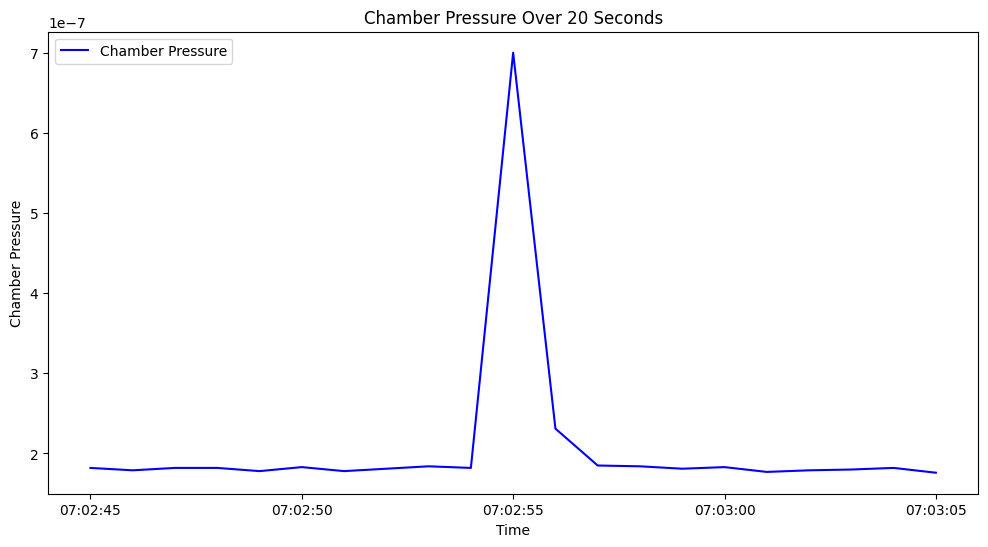

In [18]:
for t in chamber_spikes:
    pressure_window(t, 'Chamber Pressure', 10)

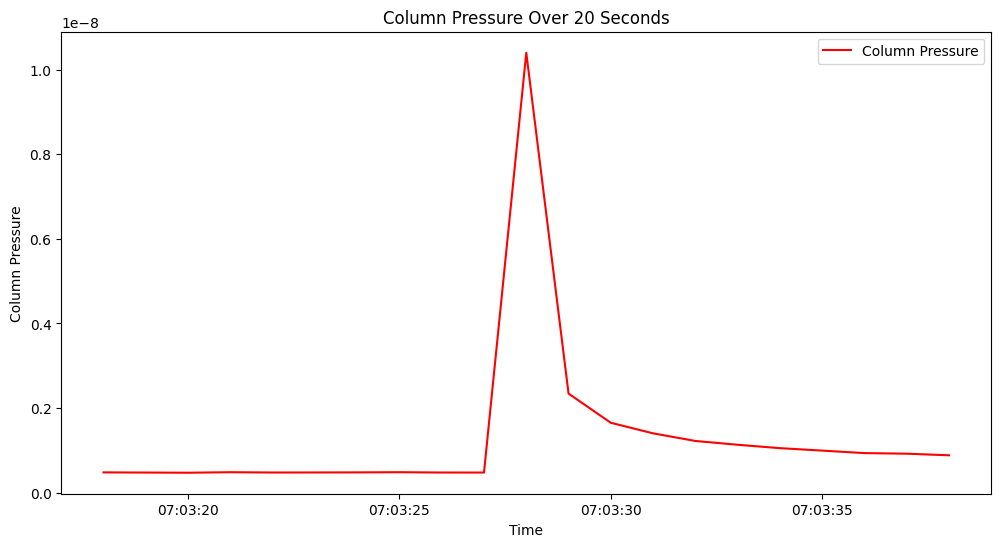

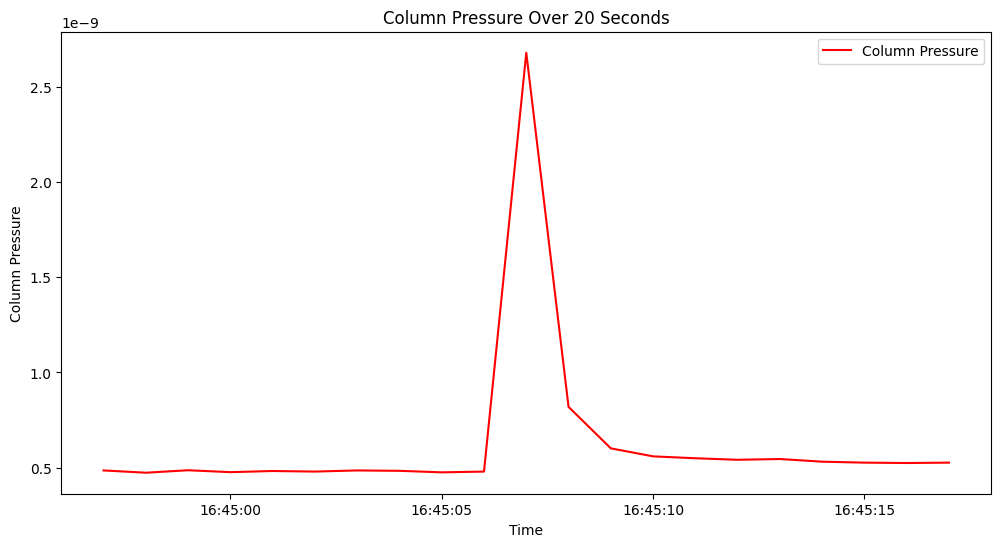

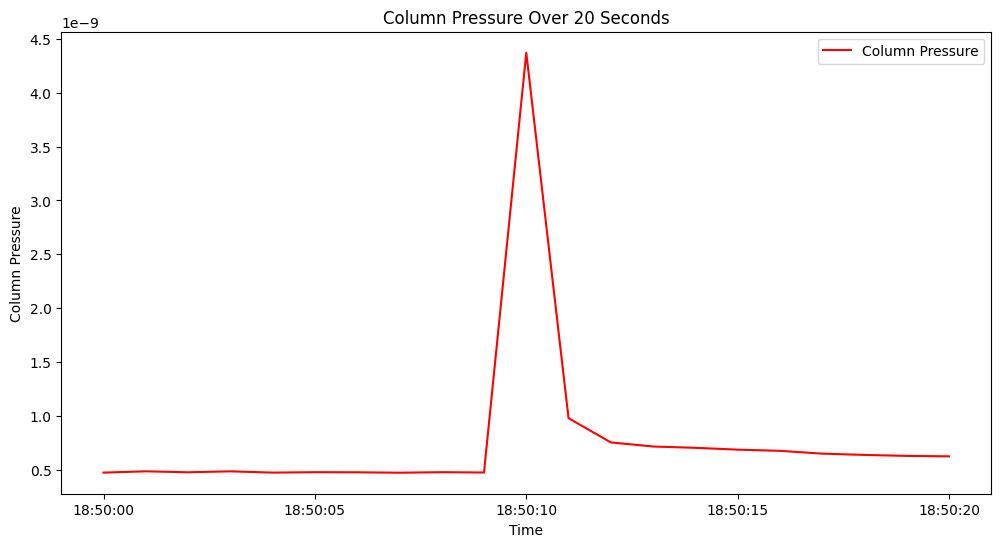

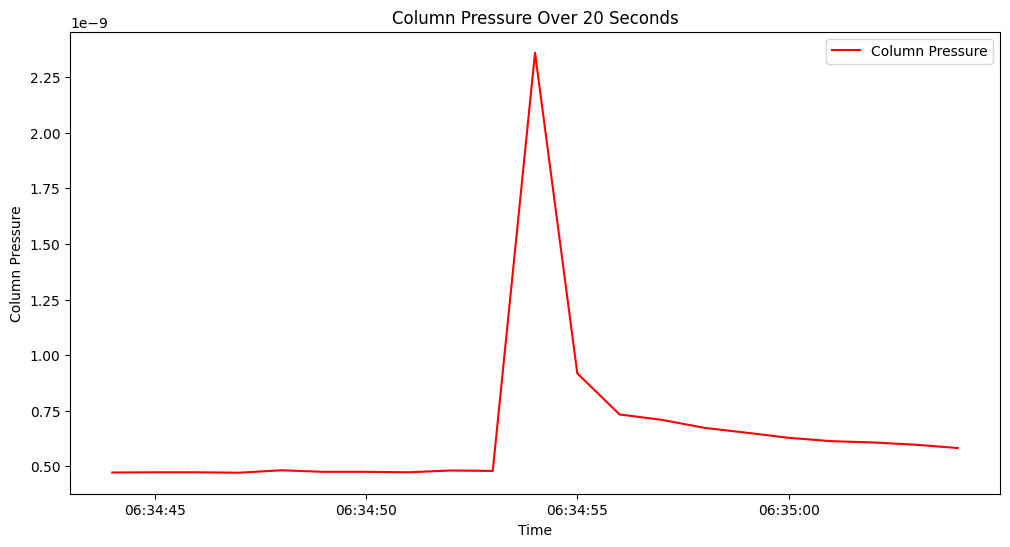

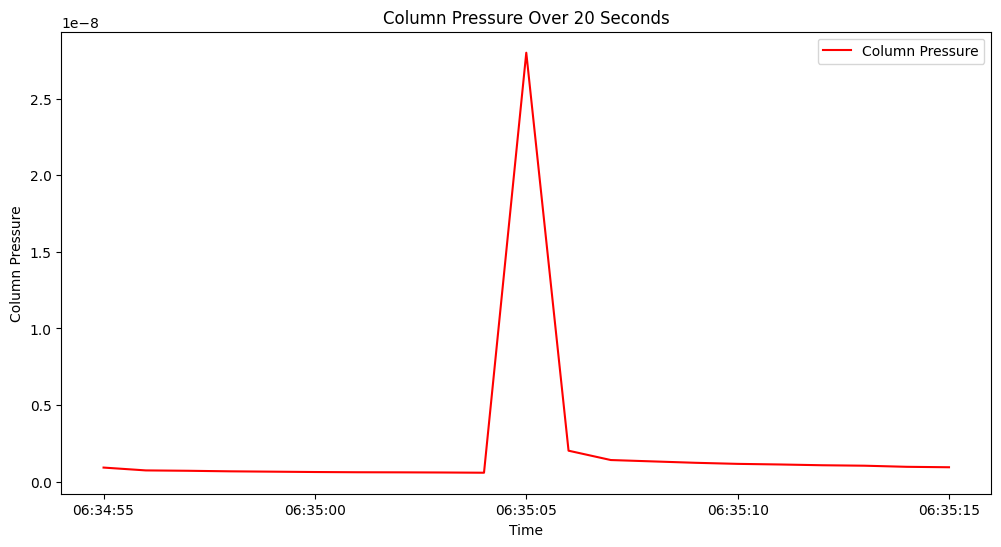

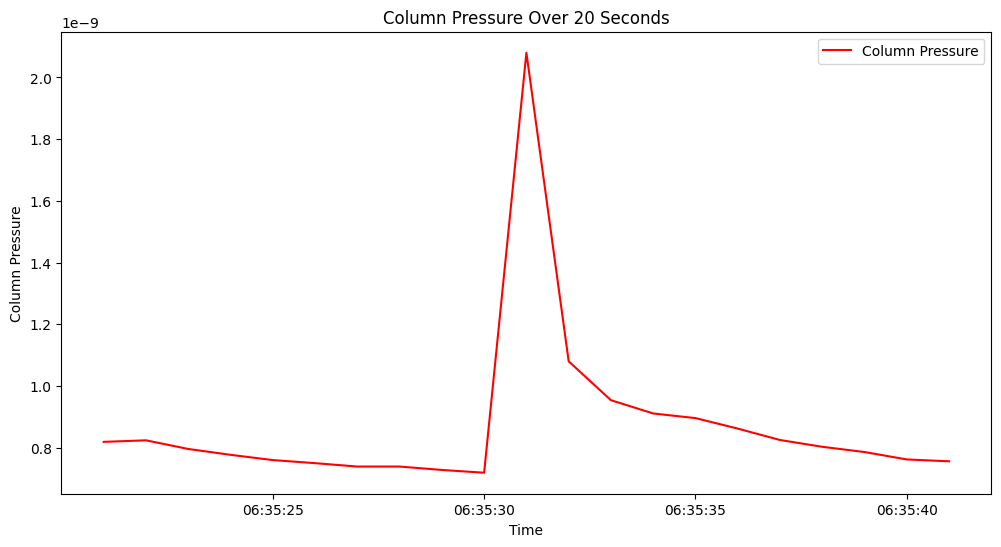

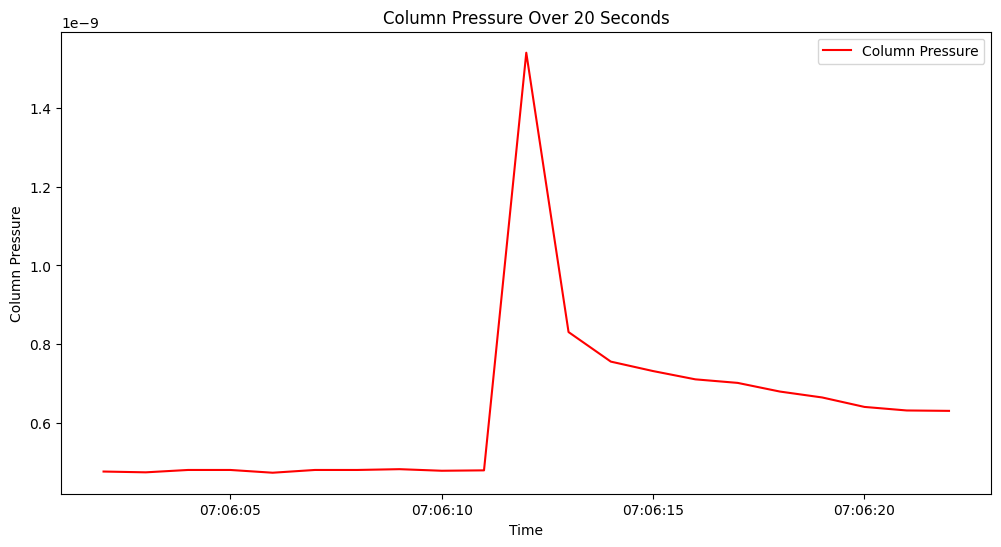

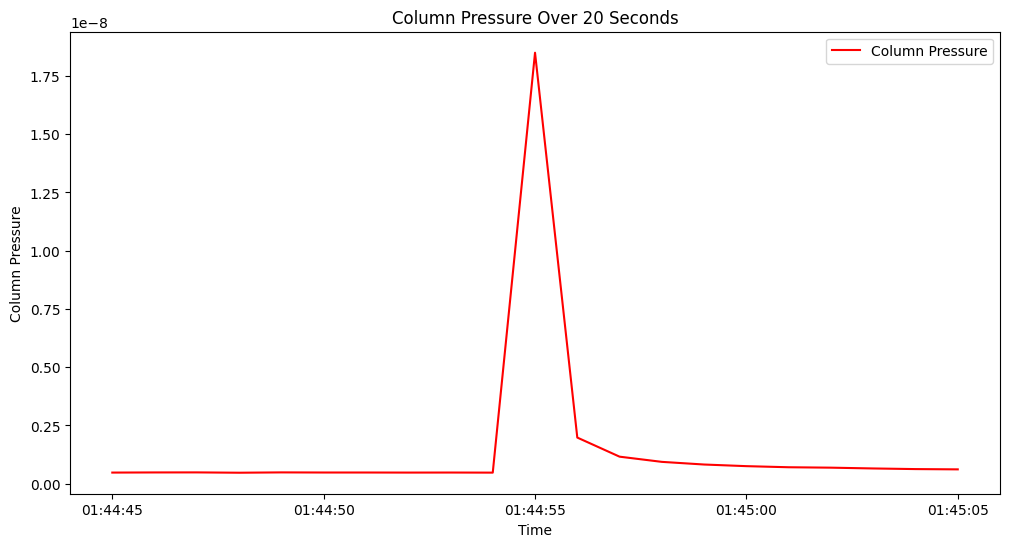

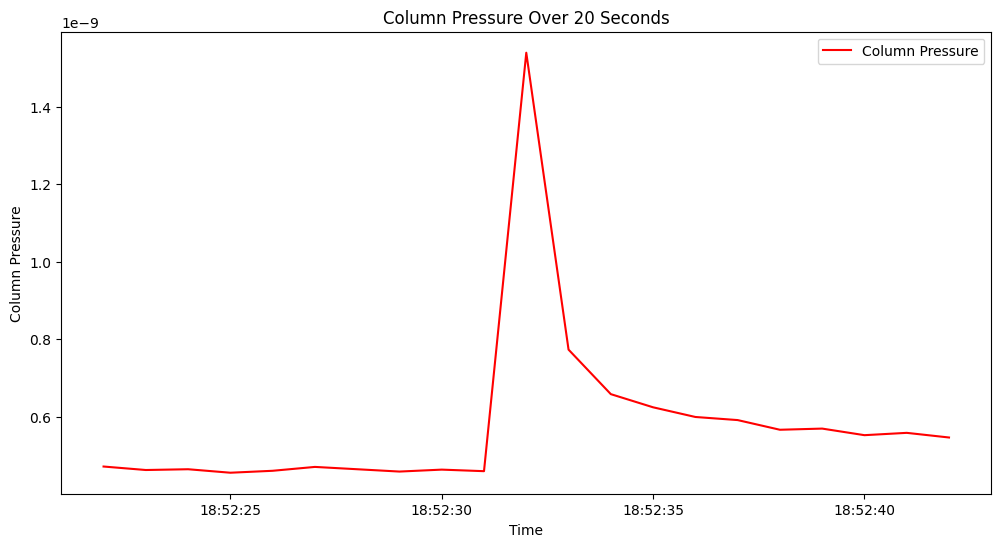

In [19]:
for t in column_spikes:
    pressure_window(t, 'Column Pressure', 10)